# Train a Meta Neural Network on NASBench
## Predict the accuracy of neural networks to within one percent!

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from nasbench import api

from data import Data
from meta_neural_net import MetaNeuralnet

/home/stephen/anaconda3/envs/bnn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/stephen/anaconda3/envs/bnn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/stephen/anaconda3/envs/bnn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/stephen/anaconda3/envs/bnn/lib/python3.6/site-

/home/stephen/anaconda3/envs/bnn/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/stephen/anaconda3/envs/bnn/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/stephen/anaconda3/envs/bnn/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/stephen/anaconda3/envs/bn

In [3]:
# define a function to plot the meta neural networks

def plot_meta_neuralnet(ytrain, train_pred, ytest, test_pred, max_disp=500, title=None):
    
    plt.scatter(ytrain[:max_disp], train_pred[:max_disp], label='training data', alpha=0.7, s=64)
    plt.scatter(ytest[:max_disp], test_pred[:max_disp], label = 'test data', alpha=0.7, marker='^')

    # axis limits
    plt.xlim((5, 15))
    plt.ylim((5, 15))
    ax_lim = np.array([np.min([plt.xlim()[0], plt.ylim()[0]]),
                    np.max([plt.xlim()[1], plt.ylim()[1]])])
    plt.xlim(ax_lim)
    plt.ylim(ax_lim)
    
    # 45-degree line
    plt.plot(ax_lim, ax_lim, 'k:') 
     
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(title)
    plt.legend(loc='best')
    plt.xlabel('true percent error')
    plt.ylabel('predicted percent error')
    plt.show()

In [4]:
# load the NASBench dataset
# takes about 1 minute to load the nasbench dataset
search_space = Data('nasbench')


Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Loaded dataset in 48 seconds


In [5]:
# method which runs a meta neural network experiment
def meta_neuralnet_experiment(params, 
                              ns=[100, 500], 
                              num_ensemble=3, 
                              test_size=500,
                              cutoff=40,
                              plot=True):
    
    for n in ns:
        for encoding_type in ['adj', 'path']:

            train_data = search_space.generate_random_dataset(num=n, 
                                                encoding_type=encoding_type,
                                                cutoff=cutoff)
            
            test_data = search_space.generate_random_dataset(num=test_size, 
                                                encoding_type=encoding_type,
                                                cutoff=cutoff)
            
            print(len(test_data))
            test_data = search_space.remove_duplicates(test_data, train_data)
            print(len(test_data))
            
            xtrain = np.array([d['encoding'] for d in train_data])
            ytrain = np.array([d['val_loss'] for d in train_data])

            xtest = np.array([d['encoding'] for d in test_data])
            ytest = np.array([d['val_loss'] for d in test_data])

            train_errors = []
            test_errors = []
            meta_neuralnet = MetaNeuralnet()
            for _ in range(num_ensemble):            
                meta_neuralnet.fit(xtrain, ytrain, **params)
                train_pred = np.squeeze(meta_neuralnet.predict(xtrain))
                train_error = np.mean(abs(train_pred-ytrain))
                train_errors.append(train_error)
                test_pred = np.squeeze(meta_neuralnet.predict(xtest))        
                test_error = np.mean(abs(test_pred-ytest))
                test_errors.append(test_error)

            train_error = np.round(np.mean(train_errors, axis=0), 3)
            test_error = np.round(np.mean(test_errors, axis=0), 3)
            print('Meta neuralnet training size: {}, encoding type: {}'.format(n, encoding_type))
            print('Train error: {}, test error: {}'.format(train_error, test_error))

            if plot:
                if encoding_type == 'path':
                    title = 'Path encoding, training set size {}'.format(n)
                else:
                    title = 'Adjacency list encoding, training set size {}'.format(n)            

                plot_meta_neuralnet(ytrain, train_pred, ytest, test_pred, title=title)
                plt.show()          
            print('correlation', np.corrcoef(ytest, test_pred)[1,0])

In [6]:
meta_neuralnet_params = {'loss':'mae', 'num_layers':10, 'layer_width':20, 'epochs':200, \
                         'batch_size':32, 'lr':.01, 'regularization':0, 'verbose':0}


500
456
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Meta neuralnet training size: 100, encoding type: adj
Train error: 0.545, test error: 2.501


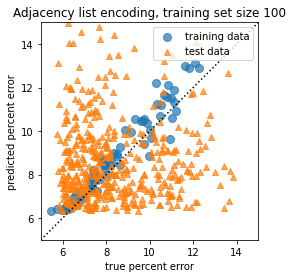

correlation 0.03735521606947776
500
447
Meta neuralnet training size: 100, encoding type: path
Train error: 0.271, test error: 1.344


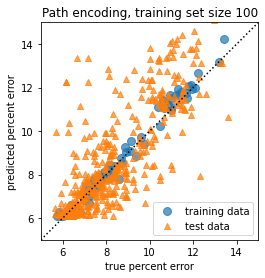

correlation 0.6019223840879773
500
365
Meta neuralnet training size: 500, encoding type: adj
Train error: 0.444, test error: 2.595


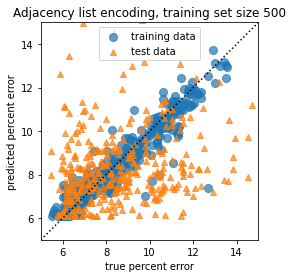

correlation 0.1835139296759116
500
356
Meta neuralnet training size: 500, encoding type: path
Train error: 0.341, test error: 1.063


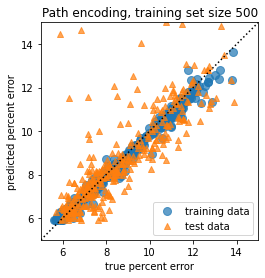

correlation 0.4473890571074836


In [7]:
meta_neuralnet_experiment(meta_neuralnet_params)